# Week 9: VAEP (Valuing Actions by Estimating Probabilities) 구현

본 노트북은 StatsBomb 공개 이벤트 데이터를 사용하여 VAEP 프레임워크를 구현하는 과정을 다룹니다.

**VAEP 프레임워크 개요:**
1.  축구 경기 데이터를 **SPADL** (Soccer Player Action Description Language) 포맷으로 변환합니다.
2.  각 액션(action)이 득점(score) 또는 실점(concede)으로 이어질 확률을 예측하는 두 개의 머신러닝 모델(XGBoost 사용)을 훈련시킵니다.
3.  두 모델의 예측값을 사용하여 각 액션의 가치(VAEP 값)를 계산합니다.
4.  계산된 VAEP 값을 바탕으로 선수 및 액션을 평가하고 시각화합니다.

In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial

In [ ]:
%cd 'UOS-FootballDataAnalytics-Tutorial/Week 9'

In [ ]:
!pip install pandera==0.13.4 scipy==1.11.4 statsbombpy

In [4]:
import os
import warnings
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

from tqdm.notebook import tqdm

In [5]:
from sklearn.metrics import (
	precision_score, 
	recall_score,
	brier_score_loss, 
	roc_auc_score, 
	log_loss, 
	f1_score,
)
import xgboost
import torch
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryCalibrationError

In [6]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import matplotsoccer as mps # 축구 이벤트 데이터 시각화
from socceraction.data.statsbomb import StatsBombLoader # StatsBomb 데이터 로더
import socceraction.spadl as spadl # SPADL 포맷 변환 및 처리

import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

### Set up the StatsBombLoader

In [7]:
# StatsBomb 데이터 로더 객체를 생성합니다. 무료 공개 데이터 접근을 위해 creds를 None으로 설정합니다.
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})
SBL

In [8]:
# 사용 가능한 대회 목록
competitions = SBL.competitions()
competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,281,9,1. Bundesliga,Germany,male,2023/2024
1,27,9,1. Bundesliga,Germany,male,2015/2016
2,107,1267,African Cup of Nations,Africa,male,2023
3,4,16,Champions League,Europe,male,2018/2019
4,1,16,Champions League,Europe,male,2017/2018
...,...,...,...,...,...,...
70,75,35,UEFA Europa League,Europe,male,1988/1989
71,315,53,UEFA Women's Euro,Europe,female,2025
72,106,53,UEFA Women's Euro,Europe,female,2022
73,107,72,Women's World Cup,International,female,2023


In [9]:
train_competitions = competitions[
    (competitions.competition_name.isin(["Premier League", "La Liga", "Serie A", "1. Bundesliga", "Ligue 1"])) &
    (competitions.season_name >= "2020/2021")
].reset_index(drop=True)

train_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,281,9,1. Bundesliga,Germany,male,2023/2024
1,90,11,La Liga,Spain,male,2020/2021
2,235,7,Ligue 1,France,male,2022/2023
3,108,7,Ligue 1,France,male,2021/2022


In [10]:
# 'FIFA World Cup' 2018 시즌
test_competitions = competitions[
	(competitions.competition_name == "FIFA World Cup")
	& (competitions.season_name == "2018")
]
test_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
30,3,43,FIFA World Cup,International,male,2018


In [11]:
train_games = pd.concat([
	SBL.games(row.competition_id, row.season_id)
	for row in train_competitions.itertuples()
]).reset_index(drop=True)

train_games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3895302,281,9,Regular Season,29,2024-04-14 17:30:00,904,176,5,0,BayArena,Harm Osmers
1,3895292,281,9,Regular Season,28,2024-04-06 15:30:00,190,904,0,1,Stadion An der Alten Försterei,Benjamin Brand
2,3895333,281,9,Regular Season,32,2024-05-05 18:30:00,184,904,1,5,Deutsche Bank Park,Christian Dingert
3,3895340,281,9,Regular Season,33,2024-05-12 20:30:00,868,904,0,5,Vonovia Ruhrstadion,Benjamin Brand
4,3895348,281,9,Regular Season,34,2024-05-18 16:30:00,904,172,2,1,BayArena,Matthias Jöllenbeck
...,...,...,...,...,...,...,...,...,...,...,...,...
122,3802948,108,7,Regular Season,38,2022-05-21 21:00:00,131,141,5,0,Parc des Princes,Antony Gautier
123,3802930,108,7,Regular Season,36,2022-05-08 20:45:00,131,133,2,2,Parc des Princes,Jérôme Brisard
124,3802793,108,7,Regular Season,16,2021-12-01 22:05:00,131,136,0,0,Parc des Princes,Clément Turpin
125,3802839,108,7,Regular Season,25,2022-02-19 22:00:00,144,131,3,1,Stade de la Beaujoire - Louis Fonteneau,Mikael Lesage


In [12]:
test_games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in test_competitions.itertuples()
]).reset_index(drop=True)

test_games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,7585,3,43,Round of 16,4,2018-07-03 20:00:00,769,768,1,1,Otkritie Bank Arena,Mark Geiger
1,7570,3,43,Group Stage,3,2018-06-28 20:00:00,768,782,0,1,Stadion Kaliningrad,Damir Skomina
2,7586,3,43,Round of 16,4,2018-07-03 16:00:00,790,773,1,0,Saint-Petersburg Stadium,Damir Skomina
3,7557,3,43,Group Stage,3,2018-06-25 20:00:00,797,780,1,1,Mordovia Arena,Enrique Cáceres
4,7542,3,43,Group Stage,2,2018-06-20 14:00:00,780,788,1,0,Stadion Luzhniki,Mark Geiger
...,...,...,...,...,...,...,...,...,...,...,...,...
59,7540,3,43,Group Stage,2,2018-06-19 20:00:00,796,774,3,1,Saint-Petersburg Stadium,Enrique Cáceres
60,8652,3,43,Quarter-finals,5,2018-07-07 20:00:00,796,785,2,2,\tOlimpiyskiy Stadion Fisht,Sandro Ricci
61,7563,3,43,Group Stage,3,2018-06-26 16:00:00,776,771,0,0,Stadion Luzhniki,Sandro Ricci
62,7556,3,43,Group Stage,2,2018-06-24 17:00:00,778,787,2,2,\tEkaterinburg Arena,Gianluca Rocchi


### 🥅 SPADL (Soccer Player Action Description Language) 전처리 및 로딩

- SPADL: StatsBomb, Opta, Wyscout 등 다양한 데이터 제공 업체의 서로 다른 이벤트 데이터 포맷을 통일된 액션 기반 포맷으로 변환하는 언어입니다.
- 현대 축구 데이터 분석 연구에서는 SPADL이라는 통일된 포맷을 사용하여 분석하는 연구가 주를 이룹니다.
- 주요 정보: 액션 유형, 시작/종료 좌표, 선수, 팀, 결과 등
- [논문링크](https://dl.acm.org/doi/10.1145/3292500.3330758)
- [Github](https://github.com/ML-KULeuven/socceraction/tree/master)

### VAEP 특징(Feature) 및 레이블(Label) 함수 정의

- Features: 현재 액션 및 이전 액션들의 유형, 위치, 시간 등
- Labels: 해당 액션 이후 정해진 시간 내에 득점(scores)이 발생했는지, 실점(concedes)이 발생했는지 여부

In [13]:
xfns = [
	fs.actiontype,
	fs.actiontype_onehot,
	fs.bodypart,
	fs.bodypart_onehot,
	fs.result,
	fs.result_onehot,
	fs.goalscore,
	fs.startlocation,
	fs.endlocation,
	fs.movement,
	fs.space_delta,
	fs.startpolar,
	fs.endpolar,
	fs.team,
	fs.time,
	fs.time_delta
]

def compute_features(actions, home_team_id, nb_prev_actions=3):
	gamestates = fs.gamestates(spadl.add_names(actions), nb_prev_actions)
	gamestates = fs.play_left_to_right(gamestates, home_team_id)

	df_features = pd.concat([fn(gamestates) for fn in xfns], axis=1)
	return df_features

In [14]:
yfns = [
	lab.scores, 
	lab.concedes
]

def compute_labels(actions):
	df_labels = pd.concat([fn(spadl.add_names(actions)) for fn in yfns], axis=1)
	return df_labels

In [15]:
def get_dataset(games):
	X_list, Y_list = [], []

	for game in tqdm(list(games.itertuples()), desc="Games processed"):
		# load data
		events = SBL.events(game.game_id)

		# StatsBomb 이벤트 데이터를 SPADL 액션 데이터로 변환합니다.
		actions = spadl.statsbomb.convert_to_actions(
				events,
				home_team_id=game.home_team_id,
				xy_fidelity_version=1,
				shot_fidelity_version=1
		)

		X_list.append(compute_features(actions, home_team_id=game.home_team_id))
		Y_list.append(compute_labels(actions))	

	X = pd.concat(X_list, axis=0).reset_index(drop=True)
	Y = pd.concat(Y_list, axis=0).reset_index(drop=True)
	
	return X, Y

In [16]:
X_train, Y_train = get_dataset(train_games)
X_test, Y_test = get_dataset(test_games)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

Games processed:   0%|          | 0/127 [00:00<?, ?it/s]

Games processed:   0%|          | 0/64 [00:00<?, ?it/s]

((269285, 163),
 (269285, 2),
 (29921, 163),
 (29921, 2),
 (128484, 163),
 (128484, 2))

In [17]:
X_train

,actiontype_a0,actiontype_a1,actiontype_a2,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,actiontype_interception_a0,actiontype_shot_a0,actiontype_shot_penalty_a0,actiontype_shot_freekick_a0,actiontype_keeper_save_a0,actiontype_keeper_claim_a0,actiontype_keeper_punch_a0,actiontype_keeper_pick_up_a0,actiontype_clearance_a0,actiontype_bad_touch_a0,actiontype_non_action_a0,actiontype_dribble_a0,actiontype_goalkick_a0,actiontype_pass_a1,actiontype_cross_a1,actiontype_throw_in_a1,actiontype_freekick_crossed_a1,actiontype_freekick_short_a1,actiontype_corner_crossed_a1,actiontype_corner_short_a1,actiontype_take_on_a1,actiontype_foul_a1,actiontype_tackle_a1,actiontype_interception_a1,actiontype_shot_a1,actiontype_shot_penalty_a1,actiontype_shot_freekick_a1,actiontype_keeper_save_a1,actiontype_keeper_claim_a1,actiontype_keeper_punch_a1,actiontype_keeper_pick_up_a1,actiontype_clearance_a1,actiontype_bad_touch_a1,actiontype_non_action_a1,actiontype_dribble_a1,actiontype_goalkick_a1,actiontype_pass_a2,actiontype_cross_a2,actiontype_throw_in_a2,actiontype_freekick_crossed_a2,actiontype_freekick_short_a2,actiontype_corner_crossed_a2,actiontype_corner_short_a2,actiontype_take_on_a2,actiontype_foul_a2,actiontype_tackle_a2,actiontype_interception_a2,actiontype_shot_a2,actiontype_shot_penalty_a2,actiontype_shot_freekick_a2,actiontype_keeper_save_a2,actiontype_keeper_claim_a2,actiontype_keeper_punch_a2,actiontype_keeper_pick_up_a2,actiontype_clearance_a2,actiontype_bad_touch_a2,actiontype_non_action_a2,actiontype_dribble_a2,actiontype_goalkick_a2,bodypart_a0,bodypart_a1,bodypart_a2,bodypart_foot_a0,bodypart_head_a0,bodypart_other_a0,bodypart_head/other_a0,bodypart_foot_a1,bodypart_head_a1,bodypart_other_a1,bodypart_head/other_a1,bodypart_foot_a2,bodypart_head_a2,bodypart_other_a2,bodypart_head/other_a2,result_a0,result_a1,result_a2,result_fail_a0,result_success_a0,result_offside_a0,result_owngoal_a0,result_yellow_card_a0,result_red_card_a0,result_fail_a1,result_success_a1,result_offside_a1,result_owngoal_a1,result_yellow_card_a1,result_red_card_a1,result_fail_a2,result_success_a2,result_offside_a2,result_owngoal_a2,result_yellow_card_a2,result_red_card_a2,goalscore_team,goalscore_opponent,goalscore_diff,start_x_a0,start_y_a0,start_x_a1,start_y_a1,start_x_a2,start_y_a2,end_x_a0,end_y_a0,end_x_a1,end_y_a1,end_x_a2,end_y_a2,dx_a0,dy_a0,movement_a0,dx_a1,dy_a1,movement_a1,dx_a2,dy_a2,movement_a2,dx_a01,dy_a01,mov_a01,dx_a02,dy_a02,mov_a02,start_dist_to_goal_a0,start_angle_to_goal_a0,start_dist_to_goal_a1,start_angle_to_goal_a1,start_dist_to_goal_a2,start_angle_to_goal_a2,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,period_id_a0,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
21559,pass,dribble,pass,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,foot,foot,foot,True,False,False,False,True,False,False,False,True,False,False,False,success,success,success,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,1,1,0,66.7625,39.525,66.7625,39.525,63.5250,46.155,65.8000,46.410,66.7625,39.525,66.7625,39.525,-0.9625,6.885,6.951952,0.0000,0.000,0.000000,3.2375,-6.630,7.378232,0.0000,0.000,0.000000,0.0000,0.000,0.000000,38.634596,0.143499,38.634596,0.143

In [18]:
Y_train

,scores,concedes
21559,False,False
78300,False,False
86138,False,False
213560,False,False
157403,False,False
...,...,...
72385,True,False
239439,False,False
101391,False,False
104634,False,False


In [19]:
# scoring 및 conceding 라벨의 분포 확인
# 두 태스크는 독립적으로 다루므로 동시에 True인 경우도 존재함
Y_train[['scores', 'concedes']].value_counts()

scores  concedes
False   False       265600
True    False         3167
False   True           512
True    True             6
dtype: int64

### VAEP 모델 훈련 (Scores & Concedes)
- VAEP 값을 계산하기 위해 두 개의 개별적인 분류 모델을 훈련.

In [20]:
xgboost_params = {
	"n_estimators": 50,
	"max_depth": 3,
	"n_jobs": -3,
	"verbosity": 1,
	"tree_method": "hist",
	"enable_categorical": True
}

Y_hat = pd.DataFrame()
models = {}
for col in tqdm(["scores", "concedes"], desc="Models trained"):
	model = xgboost.XGBClassifier(**xgboost_params)
	model.fit(X_train, Y_train[col], eval_set=[(X_valid, Y_valid[col])])
	models[col] = model

Models trained:   0%|          | 0/2 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.44795
[1]	validation_0-logloss:0.31303
[2]	validation_0-logloss:0.22878
[3]	validation_0-logloss:0.17321
[4]	validation_0-logloss:0.13541
[5]	validation_0-logloss:0.10932
[6]	validation_0-logloss:0.09121
[7]	validation_0-logloss:0.07863
[8]	validation_0-logloss:0.06983
[9]	validation_0-logloss:0.06371
[10]	validation_0-logloss:0.05955
[11]	validation_0-logloss:0.05671
[12]	validation_0-logloss:0.05484
[13]	validation_0-logloss:0.05357
[14]	validation_0-logloss:0.05278
[15]	validation_0-logloss:0.05219
[16]	validation_0-logloss:0.05179
[17]	validation_0-logloss:0.05153
[18]	validation_0-logloss:0.05134
[19]	validation_0-logloss:0.05120
[20]	validation_0-logloss:0.05112
[21]	validation_0-logloss:0.05109
[22]	validation_0-logloss:0.05102
[23]	validation_0-logloss:0.05096
[24]	validation_0-logloss:0.05093
[25]	validation_0-logloss:0.05089
[26]	validation_0-logloss:0.05085
[27]	validation_0-logloss:0.05080
[28]	validation_0-logloss:0.05077
[29]	validation_0-loglos

In [21]:
def evaluate(y, y_hat):
	bce_l1 = BinaryCalibrationError(n_bins=10, norm="l1")

	return {
		"precision": precision_score(y, y_hat > 0.5),
		"recall": recall_score(y, y_hat > 0.5),
		"f1": f1_score(y, y_hat > 0.5),
		"log_loss": log_loss(y, y_hat),
		"brier_score": brier_score_loss(y, y_hat),
		"auc": roc_auc_score(y, y_hat),
		"ece": bce_l1(torch.Tensor(y_hat.to_numpy()), torch.Tensor(y.to_numpy())).item(),
	}

for col in ["scores", "concedes"]:
	Y_hat[col] = [p[1] for p in models[col].predict_proba(X_test)]
	print(f"\n### {col} ###")
	metrics = evaluate(Y_test[col], Y_hat[col])
	
	for metric , value in metrics.items():
		print(f"{metric}: {value:.4f}")


### scores ###
precision: 0.9070
recall: 0.1448
f1: 0.2497
log_loss: 0.0456
brier_score: 0.0088
auc: 0.8123
ece: 0.0012

### concedes ###
precision: 1.0000
recall: 0.0086
f1: 0.0170
log_loss: 0.0172
brier_score: 0.0026
auc: 0.7370
ece: 0.0009


In [22]:
Y_hat

,scores,concedes
0,0.002311,0.000277
1,0.002978,0.000208
2,0.001725,0.000226
3,0.005309,0.000199
4,0.001646,0.000116
...,...,...
128479,0.092505,0.000512
128480,0.052538,0.001571
128481,0.119428,0.000974
128482,0.832979,0.003579


### VAEP 값 계산
- 모든 액션에 대해 훈련된 모델을 적용하여 'scores' 확률과 'concedes' 확률을 예측한 뒤, 각 액션의 VAEP(Valuing Actions by Estimating Probabilities) 값을 계산합니다.

* Offensive Value (공격 가치): (액션 후 득점 확률) - (액션 전 득점 확률)
* Defensive Value (수비 가치): (액션 후 실점 확률) - (액션 전 실점 확률)
* VAEP Value: (Offensive Value) + (-Defensive Value)

In [23]:
games_verbose = tqdm(list(test_games.itertuples()), desc="Loading game data")
df_teams, df_players, df_actions = [], [], []

for game in games_verbose:
	# load data
	df_teams.append(SBL.teams(game.game_id))
	df_players.append(SBL.players(game.game_id))
	events = SBL.events(game.game_id)

	# StatsBomb 이벤트 데이터를 SPADL 액션 데이터로 변환합니다.
	actions = spadl.statsbomb.convert_to_actions(
			events,
			home_team_id=game.home_team_id,
			xy_fidelity_version=1,
			shot_fidelity_version=1
	)
	df_actions.append(actions)

df_teams = pd.concat(df_teams).drop_duplicates(subset="team_id")
df_player_games = pd.concat(df_players).reset_index(drop=True) # 경기 별 선수 정보. 경기 별 선수 정보 (position, minutes_played)은 다름)
df_players = pd.concat(df_players).drop_duplicates(subset="player_id") # 선수 정보. 선수 정보 (name, nationality 등)은 동일)
df_actions = pd.concat(df_actions).reset_index(drop=True)
df_actions = pd.concat([df_actions, Y_hat], axis=1)
df_actions.head()

Loading game data:   0%|          | 0/64 [00:00<?, ?it/s]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,scores,concedes
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.24,769,3445.0,52.0625,34.425,43.3125,33.575,0,1,4,0,0.002311,0.000277
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.48,769,5692.0,43.3125,33.575,44.1875,34.425,21,1,0,1,0.002978,0.000208
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.12,769,5692.0,44.1875,34.425,40.6875,22.525,0,1,4,2,0.001725,0.000226
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.44,769,5685.0,40.6875,22.525,42.4375,21.675,21,1,0,3,0.005309,0.000199
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.20,769,5685.0,42.4375,21.675,56.4375,1.275,0,1,5,4,0.001646,0.000116


In [24]:
df_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,scores,concedes
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.240,769,3445.0,52.0625,34.425,43.3125,33.5750,0,1,4,0,0.002311,0.000277
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.480,769,5692.0,43.3125,33.575,44.1875,34.4250,21,1,0,1,0.002978,0.000208
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.120,769,5692.0,44.1875,34.425,40.6875,22.5250,0,1,4,2,0.001725,0.000226
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.440,769,5685.0,40.6875,22.525,42.4375,21.6750,21,1,0,3,0.005309,0.000199
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.200,769,5685.0,42.4375,21.675,56.4375,1.2750,0,1,5,4,0.001646,0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128479,7559,103dd34f-f30c-4afa-8062-beb741bdd69d,2,2943.213,799,5191.0,97.5625,10.625,94.9375,24.2250,0,1,5,2198,0.092505,0.000512
128480,7559,690653ec-9d8e-48fc-ae59-8f455e870aed,2,2944.012,799,5173.0,94.9375,24.225,93.1875,23.3750,21,1,0,2199,0.052538,0.001571
128481,7559,10507f7e-7b42-4be5-ab60-8f939889b605,2,2944.013,799,5173.0,93.1875,23.375,100.1875,23.3750,0,1,5,2200,0.119428,0.000974
128482,7559,84855116-f3ee-4671-b757-b9ce80d79008,2,2945.160,799,5187.0,101.0625,23.375,104.5625,37.1025,11,1,5,2201,0.832979,0.003579


In [25]:
A = []
for _, group_actions in tqdm(df_actions.groupby("game_id"), desc="Computing VAEP values"):
	group_actions = (
		spadl.add_names(group_actions)
		.merge(df_players[['player_id', 'player_name', 'nickname']], how="left")
		.merge(df_teams, how="left")
		.sort_values(["game_id", "period_id", "action_id"])
		.reset_index(drop=True)
	)

	values = vaepformula.value(group_actions, group_actions["scores"], group_actions["concedes"])
	group_actions = pd.concat([group_actions, values], axis=1)

	A.append(group_actions)

A = pd.concat(A).reset_index(drop=True)
A

Computing VAEP values:   0%|          | 0/64 [00:00<?, ?it/s]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,scores,concedes,type_name,result_name,bodypart_name,player_name,nickname,team_name,offensive_value,defensive_value,vaep_value
0,7525,e23943da-dc40-49f3-a7a0-e269288098c3,1,0.612,799,5196.0,52.0625,33.575,74.8125,32.725,0,1,5,0,0.000802,0.000278,pass,success,foot_right,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia,0.000000,-0.000000,0.000000
1,7525,fd89c08f-16ad-4102-a3ab-4dd8d58ae687,1,1.732,799,5173.0,74.8125,32.725,73.9375,33.575,21,1,0,1,0.001085,0.000253,dribble,success,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.000284,0.000025,0.000308
2,7525,c4ba0e20-8090-4285-945e-e2f9d136ae21,1,2.933,799,5173.0,73.9375,33.575,26.6875,13.175,0,0,5,2,0.002625,0.000982,pass,fail,foot_right,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.001540,-0.000729,0.000811
3,7525,576d4649-3b45-4de2-b9f7-692c3d53a12d,1,5.893,796,5175.0,32.8125,10.625,38.9375,4.675,0,0,0,3,0.001443,0.001375,pass,fail,foot,Ilya Kutepov,None,Russia,0.000461,0.001250,0.001711
4,7525,a7a37529-06c3-462f-bab5-5135acfa524a,1,7.772,799,5178.0,38.9375,4.675,25.8125,4.675,0,1,4,4,0.017590,0.000273,pass,success,foot_left,Salman Mohammed Al Faraj,Salman Al Faraj,Saudi Arabia,0.016215,0.001170,0.017385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128479,8658,ebb2fec6-914f-4518-834b-34b5363f574f,2,2977.267,785,5470.0,54.6875,11.475,23.1875,1.275,0,1,5,1702,0.018966,0.002999,pass,success,foot_right,Ivan Rakitić,None,Croatia,0.016905,-0.001312,0.015593
128480,8658,be3eeca0-2835-491f-8167-829453346a5e,2,2978.707,785,5474.0,23.1875,1.275,16.1875,2.975,21,1,0,1703,0.018192,0.001300,dribble,success,foot,Ivan Perišić,None,Croatia,-0.000774,0.001699,0.000925
128481,8658,7367be3f-74f6-4289-b8c1-344dd23eafdb,2,2982.827,785,5474.0,16.1875,2.975,3.9375,40.375,1,0,4,1704,0.044488,0.006287,cross,fail,foot_left,Ivan Perišić,None,Croatia,0.026296,-0.004988,0.021308
128482,8658,ff3f4c36-1efd-4e25-9002-d7bbbb89707a,2,2985.427,771,3099.0,3.9375,40.375,3.9375,40.375,15,1,2,1705,0.005393,0.010345,keeper_claim,success,other,Hugo Lloris,None,France,-0.000895,0.034142,0.033248


### 선수별 VAEP 평가

In [26]:
df_players

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7585,768,3094,Bamidele Alli,Dele Alli,20,True,20,Left Attacking Midfield,84
1,7585,768,3205,Kyle Walker,None,2,True,3,Right Center Back,123
2,7585,768,3233,Raheem Sterling,Raheem Sterling,10,True,22,Right Center Forward,91
3,7585,768,3244,John Stones,None,5,True,4,Center Back,132
4,7585,768,3293,Jesse Lingard,None,7,True,18,Right Attacking Midfield,132
...,...,...,...,...,...,...,...,...,...,...
27,7563,776,6303,Viktor Fischer,None,15,False,0,Substitute,34
6,7556,787,4277,Papa Alioune N''Diaye,Badou Ndiaye,17,True,13,Right Center Midfield,80
13,7559,774,6292,Essam Kamal Tawfik El Hadary,Essam El Hadary,1,True,1,Goalkeeper,101
25,7559,799,6290,Motaz Ali Hassan Hawsawi,Motaz Hawsawi,23,True,5,Left Center Back,101


In [27]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(df_players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
248,5470.0,Ivan Rakitić,4.168220,3.875864,0.292356,833
6,3009.0,Kylian Mbappé,3.776591,3.831018,-0.054427,489
152,5186.0,Denis Cheryshev,3.398235,3.484619,-0.086384,213
599,20004.0,Paul Pogba,3.373010,3.009111,0.363899,673
50,3308.0,Kieran Trippier,3.267455,2.966929,0.300526,684
92,3621.0,Eden Hazard,2.836822,2.905241,-0.068419,687
36,3244.0,John Stones,2.817121,2.288920,0.528201,934
121,4319.0,Edinson Cavani,2.803066,2.744264,0.058801,224
17,3089.0,Kevin De Bruyne,2.779690,2.821333,-0.041643,714
352,5574.0,Toni Kroos,2.672730,2.632065,0.040665,641


In [28]:
# Normalize for minutes played
minutes_played = df_player_games.groupby("player_id").sum().reset_index()

stats = playersR.merge(minutes_played)
stats = stats[stats.minutes_played > 90*  2] # at least four full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,game_id,team_id,jersey_number,is_starter,starting_position_id,minutes_played,vaep_rating,offensive_rating,defensive_rating
152,5186.0,Denis Cheryshev,3.398235,3.484619,-0.086384,213,38857,3980,30,3,63,317,0.964799,0.989324,-0.024526
251,5473.0,Ahmed Musa,2.065251,2.082792,-0.017541,161,22642,2325,21,2,46,224,0.829788,0.836836,-0.007048
352,5574.0,Toni Kroos,2.672730,2.632065,0.040665,641,22652,2310,24,3,41,295,0.815409,0.803003,0.012406
121,4319.0,Edinson Cavani,2.803066,2.744264,0.058801,224,30259,3132,84,4,90,362,0.696895,0.682276,0.014619
6,3009.0,Kylian Mbappé,3.776591,3.831018,-0.054427,489,56181,5397,70,6,97,559,0.608038,0.616801,-0.008763
451,5674.0,Moussa Wagué,1.703835,1.584307,0.119527,169,22666,2361,66,2,4,257,0.596674,0.554816,0.041858
248,5470.0,Ivan Rakitić,4.168220,3.875864,0.292356,833,56182,5495,49,6,91,691,0.542894,0.504816,0.038078
525,6196.0,Yerry Mina,2.178834,2.082048,0.096786,324,22711,2307,39,3,9,374,0.524318,0.501028,0.023291
75,3531.0,Mohamed Salah,1.115177,1.105236,0.009941,121,15099,1548,20,2,36,195,0.514697,0.510109,0.004588
599,20004.0,Paul Pogba,3.373010,3.009111,0.363899,673,48618,4626,36,6,74,619,0.490421,0.437512,0.052909


### 포지션 / 선수별 VAEP 평가

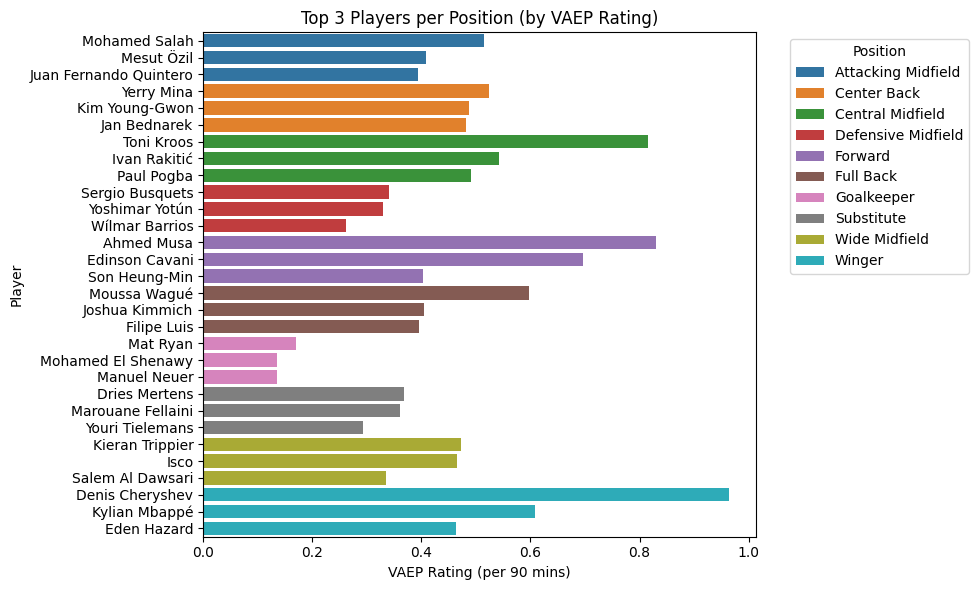

player_id             player_name  vaep_value  \
main_position                                                           
Attacking Midfield 75      3531.0           Mohamed Salah    1.115177   
                   69      3496.0              Mesut Özil    0.889564   
                   469     5692.0  Juan Fernando Quintero    1.609351   
Center Back        525     6196.0              Yerry Mina    2.178834   
                   382     5604.0          Kim Young-Gwon    1.592810   
                   129     4626.0            Jan Bednarek    1.300130   
Central Midfield   352     5574.0              Toni Kroos    2.672730   
                   248     5470.0            Ivan Rakitić    4.168220   
                   599    20004.0              Paul Pogba    3.373010   
Defensive Midfield 169     5203.0         Sergio Busquets    1.575264   
                   307     5529.0          Yoshimar Yotún    0.689932   
                   463     5686.0          Wílmar Barrios    0.865197   
Forward            251     5473.0              Ahmed Musa    2.065251   
                   121     4319.0          Edinson Cavani    2.803066   
                   16      3083.0           Son Heung-Min    1.316951   
Full Back          451     5674.0            Moussa Wagué    1.703835   
                   357     5579.0          Joshua Kimmich    1.325356   
                   551     6320.0             Filipe Luis    0.794599   
Goalkeeper         35      3240.0                Mat Ryan    0.543478   
                   228     5265.0      Mohamed El Shenawy    0.287807   
                   348     5570.0            Manuel Neuer    0.443890   
Substitute         407     5630.0           Dries Mertens    1.299055   
                   47      3296.0       Marouane Fellaini    1.341564   
                   2       2954.0         Youri Tielemans    0.616141   
Wide Midfield      50      3308.0         Kieran Trippier    3.267455   
                   135     4926.0                    Isco    2.152746   
                   153     5187.0        Salem Al Dawsari    1.091052   
Winger             152     5186.0         Denis Cheryshev    3.398235   
                   6       3009.0           Kylian Mbappé    3.776591   
                   92      3621.0             Eden Hazard    2.836822   

                        offensive_value  defensive_value  count  \
main_position                                                     
Attacking Midfield 75          1.105236         0.009941    121   
                   69          0.870738         0.018825    359   
                   469         1.684303        -0.074952    375   
Center Back        525         2.082048         0.096786    324   
                   382         1.338093         0.254717    182   
                   129         1.104103         0.196026    316   
Central Midfield   352         2.632065         0.040665    641   
                   248         3.875864         0.292356    833   
                   599         3.009111         0.363899    673   
Defensive Midfield 169         1.580869        -0.005606    573   
                   307         0.593998         0.095934    271   
                   463         0.299165         0.566032    274   
Forward            251         2.082792        -0.017541    161   
                   121         2.744264         0.058801    224   
                   16          1.367671        -0.050720    227   
Full Back          451         1.584307         0.119527    169   
                   357         1.242445         0.082911    517   
                   551         0.755643         0.038955    243   
Goalkeeper         35          0.130570         0.412908    202   
                   228         0.121663         0.166144     68   
                   348         0.104533         0.339356    157   
Substitute         407         1.311305        -0.012250    273   
                   47          1.112063         0.229501    311   
            

In [29]:
simplified_positions = {
    # GK
    "Goalkeeper": "Goalkeeper",

    # DEF
    "Left Back": "Full Back",
    "Right Back": "Full Back",
    "Left Wing Back": "Full Back",
    "Right Wing Back": "Full Back",
    "Left Center Back": "Center Back",
    "Right Center Back": "Center Back",
    "Center Back": "Center Back",

    # MID
    "Center Defensive Midfield": "Defensive Midfield",
    "Left Defensive Midfield": "Defensive Midfield",
    "Right Defensive Midfield": "Defensive Midfield",
    "Left Center Midfield": "Central Midfield",
    "Right Center Midfield": "Central Midfield",
    "Left Midfield": "Wide Midfield",
    "Right Midfield": "Wide Midfield",
    "Center Attacking Midfield": "Attacking Midfield",
    "Left Attacking Midfield": "Attacking Midfield",
    "Right Attacking Midfield": "Attacking Midfield",

    # FWD
    "Center Forward": "Forward",
    "Left Center Forward": "Forward",
    "Right Center Forward": "Forward",
    "Left Wing": "Winger",
    "Right Wing": "Winger",

    # Other
    "Substitute": "Substitute",
}

position_played = df_player_games.groupby("player_id").agg(
    minutes_played = ("minutes_played", "sum"),
    main_position = ("starting_position_name", lambda x: x.mode()[0])
).reset_index()

stats_pos = playersR.merge(position_played, how="left", on="player_id")
stats_pos = stats_pos[stats_pos.minutes_played > 180] # at least two full games played
stats_pos["main_position"] = stats_pos["main_position"].map(simplified_positions)
stats_pos = stats_pos[stats_pos["main_position"] != "Other"]
stats_pos["vaep_rating"] = stats_pos.vaep_value * 90 / stats_pos.minutes_played
stats_pos["offensive_rating"] = stats_pos.offensive_value * 90 / stats_pos.minutes_played
stats_pos["defensive_rating"] = stats_pos.defensive_value * 90 / stats_pos.minutes_played

# 포지션별 상위 3명 추출
top_players = (
    stats_pos.groupby("main_position")
    .apply(lambda x: x.nlargest(3, "vaep_rating"))
    .reset_index(drop=True)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_players,
    y="player_name",
    x="vaep_rating",
    hue="main_position",
    dodge=False
)
plt.title("Top 3 Players per Position (by VAEP Rating)")
plt.xlabel("VAEP Rating (per 90 mins)")
plt.ylabel("Player")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

stats_pos.groupby("main_position").apply(
	lambda x: x.sort_values("vaep_rating", ascending=False).head(3)
)

### SPADL 데이터 시각화

- [matplotsoccer](https://github.com/TomDecroos/matplotsoccer/tree/master): 축구 이벤트/액션 데이터를 경기장 위에 시각화하는 라이브러리.

In [30]:
def nice_time(row):
	minute = int((row.period_id-1)*45 +row.time_seconds // 60)
	second = int(row.time_seconds % 60)
	return f"{minute}m{second}s"

def plot_actions(a: pd.DataFrame, g: pd.Series) -> None:
	home_team_name = df_teams[df_teams.team_id == g.home_team_id].team_name.values[0]
	away_team_name = df_teams[df_teams.team_id == g.away_team_id].team_name.values[0]

	minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
	game_info = f"{g.game_date} {home_team_name} {g.home_score}-{g.away_score} {away_team_name} {minute + 1}'"
	print(game_info)

	a["player_name"] = a.player_id.map(df_players.set_index("player_id").player_name)
	a["team_name"] = a.team_id.map(df_teams.set_index("team_id").team_name)
	a["type_name"] = a.type_id.map(spadl.config.actiontypes_df().type_name.to_dict())
	a["result_name"] = a.result_id.map(spadl.config.results_df().result_name.to_dict())
	a["nice_time"] = a.apply(nice_time, axis=1)

	if "vaep_value" in a.columns:
		for col in ["scores", "concedes", "offensive_value", "defensive_value", "vaep_value"]:
			a[col] = a[col].map(lambda x: f"{x:.3f}")

		labels = a[["nice_time", "type_name", "result_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]]
		labeltitle = ["time", "actiontype", "result", "player", "team", "scores", "concedes", "vaep_value"]
	else:
		labels = a[["nice_time", "type_name", "player_name", "team_name"]]
		labeltitle = ["time", "actiontype", "player", "team"]

	mps.actions(
		location=a[["start_x", "start_y", "end_x", "end_y"]],
		action_type=a.type_name,
		team= a.team_name,
		result= a.result_name == "success",
		label=labels,
		labeltitle=labeltitle,
		zoom=False,
		figsize=6,
		color="green"
	)

2018-06-27 16:00:00 South Korea 2-0 Germany 90'


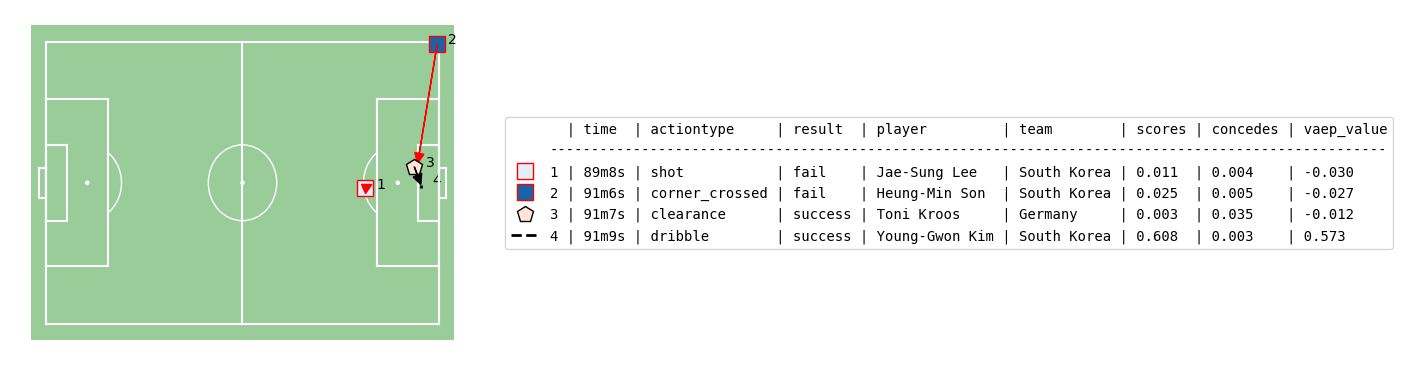

2018-06-18 14:00:00 Sweden 1-0 South Korea 56'


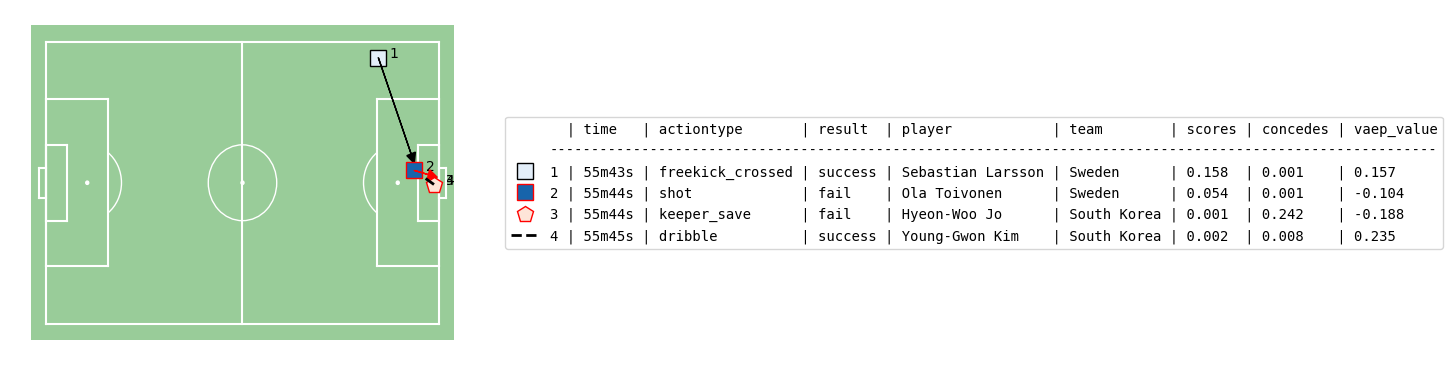

2018-06-27 16:00:00 South Korea 2-0 Germany 52'


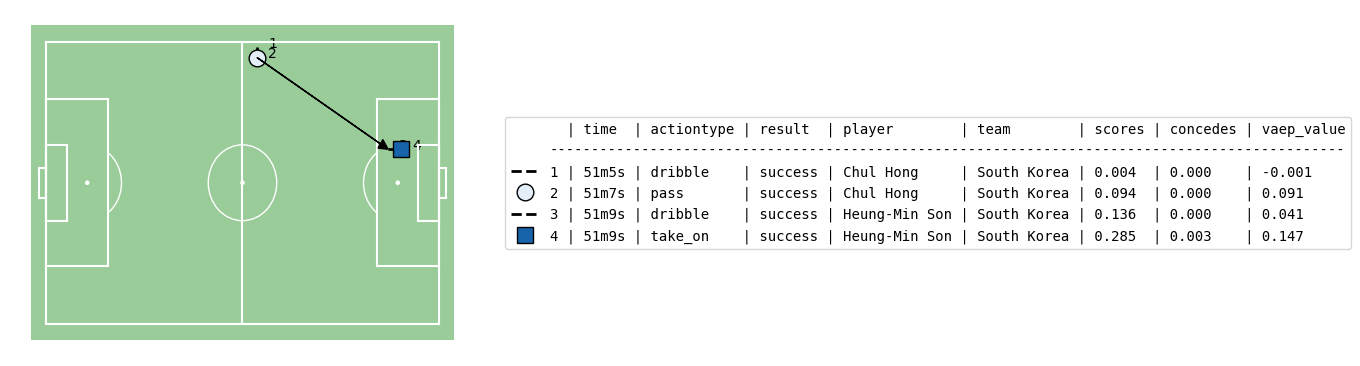

2018-06-27 16:00:00 South Korea 2-0 Germany 96'


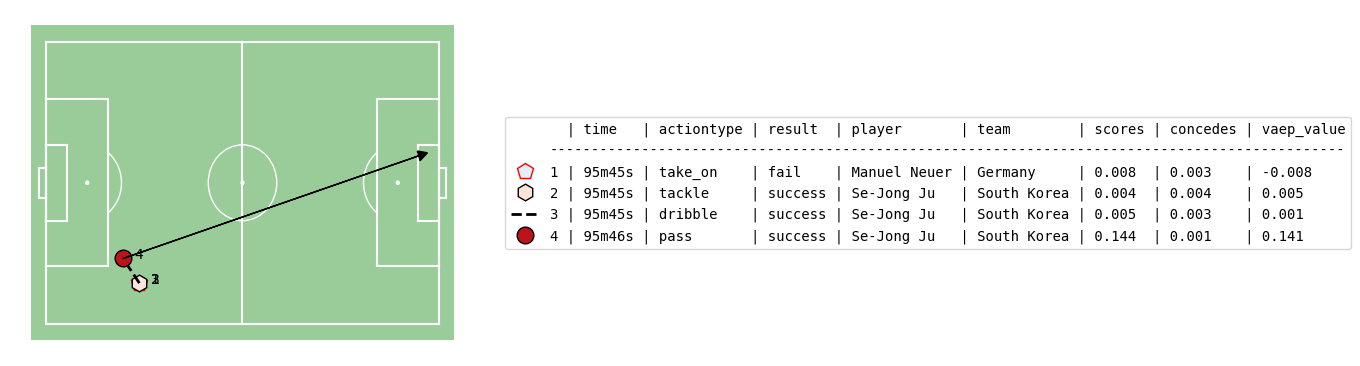

2018-06-27 16:00:00 South Korea 2-0 Germany 66'


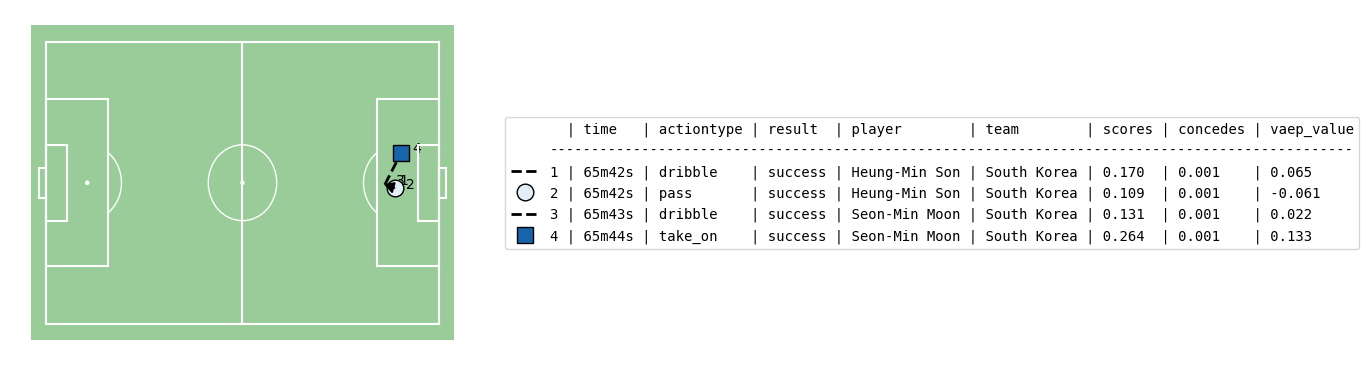

In [36]:
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "South Korea"] # view only actions from south korea
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id, time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = int(time_seconds % 60)
    return f"{m}m{s}s"

for j in range(0, 5):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+1].copy()
    g = list(test_games[test_games.game_id == a.game_id.values[0]].itertuples())[0]

    plot_actions(a, g)